#Stock Prediction deep learning model with LSTM
###Final Year Project by Devansh Gupta
#### Disclaimer 
I am not a financial advisor and any information displayed in this paper should not be used as financial advice. Trade at your own risk.

## Introduction and Pre-Analysis

Stock price prediction is a challenging and important problem in finance. Accurate predictions can help investors make informed decisions and maximize profits. In recent years, machine learning models such as LSTM have been used to predict stock prices with promising results. In this project, we aim to develop an LSTM model to predict stock prices of Tesla (TSLA). Please note that this notebook is flexible tfor other stocks and one can place a ticker symbol in the code and the notebook will function normally. We will dynamically scrape historical data from the Yahoo Finance website, select relevant features using RFE with a linear regression estimator, and tune hyperparameters using k-fold cross-validation. We will evaluate the performance of our model using RMSE, MAPE, and MAE metrics, and make future predictions using the final model.

### To start our analysis for the multivariate LSTM predictor:

We will dynamically scrape historical data from the Yahoo Finance website. We will use the Python library Requests_html to check the health of the website and extract data for TSLA from the past few years. We will then preprocess the data by filling any missing values and filtering out rows with invalid data.

Next, we will select relevant features for our LSTM model. To do this, we will use Recursive Feature Elimination (RFE) with a linear regression estimator to rank the importance of each feature. We will set the number of features to select to 5 based on prior knowledge of the TSLA stock market.

To establish a baseline for our model's performance, we will use the root mean squared error (RMSE), mean absolute percentage error (MAPE), and mean absolute error (MAE) metrics. We will split the data into training and testing sets and train a baseline model using a simple regression algorithm.

To optimize the hyperparameters of our LSTM model, we will use k-fold cross-validation. This will help us tune parameters such as the number of hidden layers and the number of neurons per layer.

Finally, we will implement our final LSTM model and use it to make future predictions. We will evaluate the performance of our final model using the same metrics as the baseline and compare the results to determine the effectiveness of our approach.

## Some important terminolgy:
MA10 - 10 day moving average.

MA20 - 20 day moving average.

Crossover - When the MA10 cuts the MA20 from below to above the MA20 line.

Crossunder - When the MA10 dips below the MA20 from above the MA20 line.

Market Open Price - The price at which the stock starts at in a new day (or new minute, depends on interval).

Buy Price - Price at which the software has decided to buy the stock.

Sell Price - Price at which the software has decided to sell the stock.

In [ ]:
!pip install requests_html

In [4]:
import pandas as pd
import numpy as np
import time 
import datetime
import mplfinance as mpf
from pandas_datareader import data
import matplotlib.pyplot as plt
import datetime as dt
import urllib.request, json
import os
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.layers import Dropout
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from requests_html import HTMLSession

## Load data

Load all updated financial data to be used from a CSV URL provided by https://finance.yahoo.com/ via web scraping. The website is reliable and provides free data available for download. Other websites do not provide all collumns of data which makes it hard to plot the candles on the chart for visualization. A URL is formatted to include the date range of the data, and the stock code itself. It will then read the URL which has a CSV with the appropriate data embedded in it. Data is from January 2005 to present day.

In [5]:
def load_data(ticker):
  #defining date range and intervals of data using library datetime
    start_period = int(time.mktime(datetime.datetime(2005,1,1,23,59).timetuple()))
    end_period = int(time.mktime(datetime.datetime.now().timetuple()))
    interval = '1d'
    #modifying URL
    url = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={start_period}&period2={end_period}&interval={interval}&events=history&includeAdjustedClose=true'
    
    #getting URL functional status/checking for 404 using library requests_html 
    session = HTMLSession()
    r = str(session.get(url))
    
    #checking if the URL works
    if r == '<Response [200]>':  
        df = pd.read_csv(url)
        print('Data taken from Yahoo website. The reponse is ', r)
    else:
        df = pd.read_csv('data/' + ticker + '_data.csv')
        print('Data taken from local CSV files since yahoo servers are down.')

    # cleaning the code
    # df.dropna(inplace=True)
    df.fillna(value='', inplace=True)
    df = df[(df['Close'] > 0) & (df['Open'] > 0) & (df['High'] > 0) & (df['Low'] > 0)]
    
    #adding all features
    df.Date = pd.to_datetime(df.Date)
    df = df.set_index(df.Date)
    df['Moving Average - 10 day'] = df['Close'].rolling(window=10).mean()
    df['Moving Average - 20 day'] = df['Close'].rolling(window=20).mean()
    ma =  df['Close'].rolling(window=20).mean()
    df['Upper Bollinger Band'] = ma + 2*(df['Close'].rolling(window=20).std())
    df['Lower Bollinger Band'] = ma - 2*(df['Close'].rolling(window=20).std())

    #Dropping first 20 elements of code to get rid of NaN values caused by features
    df = df.drop(df.index[:20])

    
    print(df.shape)
    

    return df
df = load_data("tsla")
df.head()


Data taken from Yahoo website. The reponse is  <Response [200]>
(3187, 11)


,Date,Open,High,Low,Close,Adj Close,Volume,Moving Average - 10 day,Moving Average - 20 day,Upper Bollinger Band,Lower Bollinger Band
Date,,,,,,,,,,,
2010-07-28,2010-07-28,1.370000,1.393333,1.367333,1.381333,1.381333,7008000,1.383133,1.314200,1.595001,1.033399
2010-07-29,2010-07-29,1.384667,1.392000,1.333333,1.356667,1.356667,9240000,1.386200,1.302600,1.553205,1.051995
2010-07-30,2010-07-30,1.346667,1.362667,1.303333,1.329333,1.329333,6403500,1.381533,1.295867,1.535196,1.056537
2010-08-02,2010-08-02,1.366667,1.398000,1.355333,1.394667,1.394667,10771500,1.374933,1.301600,1.544792,1.058408
2010-08-03,2010-08-03,1.400000,1.463333,1.388000,1.463333,1.463333,18457500,1.385933,1.321067,1.549425,1.092708


## Plotting data with some features
Plotting and visualizing the data retrieved.

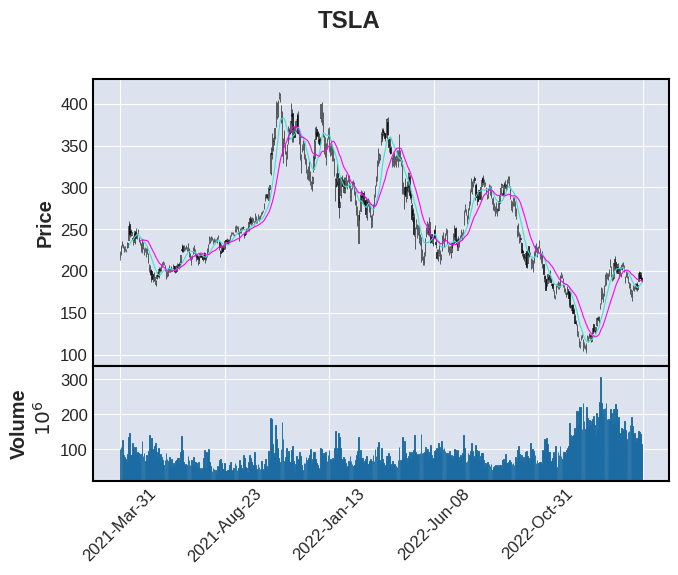

In [6]:
import mplfinance as mpf

# Define the kwargs for the plot
kwargs = dict(type='candle', mav=(10,20), volume=True, 
              title='TSLA', ylabel='Price', ylabel_lower='Volume')

# Plot the data using mplfinance
mpf.plot(df[-500:], **kwargs)


## Feature selection
Dynamically choosing all the features 

We select the target variable and features for our model and use RFE with a linear regression estimator to choose the top 5 features. We perform time series cross-validation and extract the selected feature names from the support_ attribute of the selector.

In [7]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

target_variable = 'Close'

def select_features(df):
  # Select target variable
  

  # Select features for model
  X = df.drop(['Date', target_variable], axis=1)
  y = df[target_variable]

  # Recursive feature elimination with cross-validation
  estimator = LinearRegression()
  selector = RFE(estimator, n_features_to_select=5, step=1)
  cv = TimeSeriesSplit(n_splits=5)
  X_new = selector.fit_transform(X, y)

  selected_features = X.columns[selector.get_support()]

  print('')
  print('Features selected:')
  for feature in selected_features:
    print(feature)
  print('')
  return selected_features

# Using multiple features (predictors)
testdf = df.values

print('Shape of training set == {}.'.format(testdf.shape))
# testdf

Shape of training set == (3187, 11).


## Data processing for LSTM Model
This section prepares the data in the way that the keras and tensorflow libraries can ingest it to make predictions with the model.

In [8]:
n_future = 60   # Number of days we want top predict into the future
n_past = 90     # Number of past days we want to use to predict the future

def process_data(df):
  columns = [target_variable]
  for feature in select_features(df):
    columns.append(feature)

  df = df[columns].astype(str)
  for i in columns:
    for j in range(0, len(df)):
        df[i][j] = df[i][j].replace(',', '')
  df = df.astype('float32')
  # Using multiple features (predictors)
  testdf = df.values
  print('Shape of training set == {}.'.format(testdf.shape))
  # testdf

  # preprocess data
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled_data = scaler.fit_transform(testdf)
  sc_predict = MinMaxScaler()
  sc_predict.fit_transform(testdf[:, 0:1])

  # Creating a data structure with look_back timestamps and 1 output
  X_train = []
  y_train = []

  for i in range(n_past, len(scaled_data) - n_future + 1):
    X_train.append(scaled_data[i - n_past:i, 0:testdf.shape[1] - 1])
    y_train.append([scaled_data[i + n_future - 1:i + n_future, 0]])  # wrap y_train value in a list

  X_train = np.array(X_train)
  y_train = np.array(y_train, dtype=object)
  y_train = y_train.astype('float32')
  print('X_train shape == {}.'.format(X_train.shape))
  print('y_train shape == {}.'.format(y_train.shape))
  print('')

  return X_train, y_train, scaled_data, testdf


##Baseline performance 

This baseline is calculated with a simple LSTM model


In [9]:
X_train, y_train, scaled_data, testdf = process_data(load_data("tsla"))

# build LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# train LSTM model
model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=1)

# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

# predictions_train = model.predict(X_train[n_past:])

# calculate root mean squared error
rmse = np.sqrt(np.mean((predictions_future - y_train)**2))
print('RMSE:', rmse)

Data taken from Yahoo website. The reponse is  <Response [200]>
(3187, 11)

Features selected:
Open
High
Low
Adj Close
Volume

Shape of training set == (3187, 6).
X_train shape == (3038, 90, 5).
y_train shape == (3038, 1, 1).

Epoch 1/5
95/95 [==============================] - 7s 39ms/step - loss: 0.0086
Epoch 2/5
95/95 [==============================] - 5s 53ms/step - loss: 0.0048
Epoch 3/5
95/95 [==============================] - 4s 40ms/step - loss: 0.0047
Epoch 4/5
95/95 [==============================] - 4s 38ms/step - loss: 0.0046
Epoch 5/5
2/2 [==============================] - 1s 17ms/step
RMSE: 0.4871401


## Apply LSTM Model with K Fold

This section is implemented as a testing ground for us as an evaluation tool to experiment with what sort of models would work. This code was used with a number of references to see what settings would best fit the model that is perfect. This method can also be implemented dynamically to have the code figure out the optimal model for us in the case of switching different datasets.

### Brief analysis
This code is performing a time series analysis using a neural network based on LSTM. It is using K-fold cross-validation to evaluate the performance of the model. The code initializes the neural network and defines the optimizer, loss function, and metric for the model. It then splits the data into training and validation sets for each fold and fits the model using the training data and validates using the validation data. The evaluation metrics and training history are stored and averaged across all folds and iterations. Finally, the average MAE and loss history are plotted for visualization. The code provides a useful framework for performing time series analysis using a neural network and evaluating its performance using cross-validation.

X shape == (2698, 90, 5).
y shape == (2698, 1, 1).
processing fold 0
Epoch 1/10
113/113 [==============================] - 17s 105ms/step - loss: 0.0506 - mae: 0.1724 - val_loss: 0.0145 - val_mae: 0.1176
Epoch 2/10
113/113 [==============================] - 13s 115ms/step - loss: 0.0488 - mae: 0.1649 - val_loss: 0.0436 - val_mae: 0.2084
Epoch 3/10
113/113 [==============================] - 11s 98ms/step - loss: 0.0649 - mae: 0.2099 - val_loss: 0.0212 - val_mae: 0.1448
Epoch 4/10
113/113 [==============================] - 11s 99ms/step - loss: 0.0481 - mae: 0.1758 - val_loss: 0.0140 - val_mae: 0.1173
Epoch 5/10
113/113 [==============================] - 11s 99ms/step - loss: 0.0441 - mae: 0.1659 - val_loss: 0.0144 - val_mae: 0.1189
Epoch 6/10
113/113 [==============================] - 10s 84ms/step - loss: 0.0435 - mae: 0.1626 - val_loss: 0.0128 - val_mae: 0.1127
Epoch 7/10
113/113 [==============================] - 11s 98ms/step - loss: 0.0416 - mae: 0.1578 - val_loss: 0.0055 - val_mae

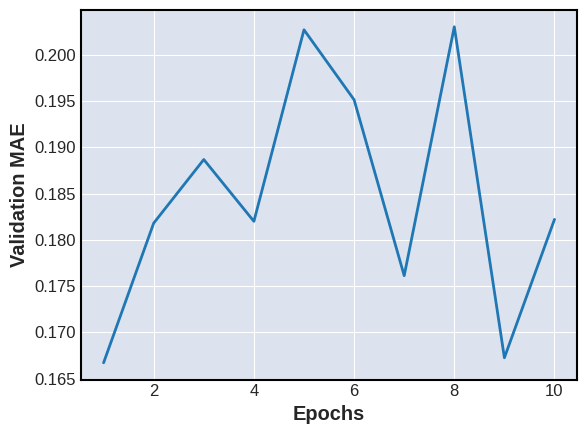

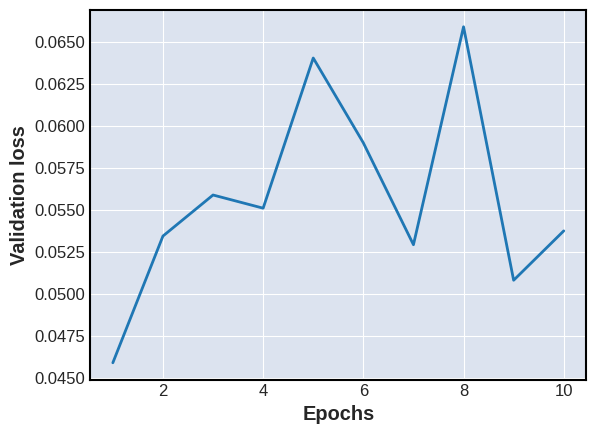

In [15]:
X = []
y = []

for i in range(n_past, len(scaled_data) - n_future + 1):
    X.append(scaled_data[i - n_past:i, 0:testdf.shape[1] - 1])
    y.append([scaled_data[i + n_future - 1:i + n_future, 0]])  # wrap y_train value in a list

X = np.array(X)
y = np.array(y, dtype=object)

# print('y shape == {}.'.format(y.shape))
y = y.astype('float32')

tensor = tf.convert_to_tensor(y)

print('X shape == {}.'.format(X.shape))
print('y shape == {}.'.format(y.shape))

# Initializing the Neural Network based on LSTM
model = Sequential()
# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, testdf.shape[1]-1)))

# Adding 2nd LSTM layer
model.add(LSTM(units=10, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Define the optimizer, loss function, and metric for the model
# optimizer = optimizers.Adam(lr=0.01) 
model.compile(optimizer = Adam(learning_rate=0.01), loss='mse', metrics=['mae']) 

# Define the hyperparameters for K-fold cross-validation
K = 4 
num_val_samples = len(X) // K 
num_epochs = 10 
N_iterations = 4 
N_folds = 3 

# Initialize lists 
all_val_mae = []
all_val_mse = []
all_mae = []
all_loss = []
all_mae_history = []
all_loss_history = []

# Perform K-fold cross-validation
for i in range(N_iterations):
    kf = KFold(n_splits=N_folds, shuffle=False) # instantiate a KFold object with N_folds splits
    for j, (train_index, val_index) in enumerate(kf.split(X)):
        print('processing fold', j)
        # Split the data into training and validation sets for this fold
        partial_train_data = X[train_index]
        partial_train_targets = y[train_index]
        val_data = X[val_index]
        val_targets = y[val_index]
        
        # Fit the model using the training data and validate using the validation data
        history = model.fit(partial_train_data, partial_train_targets,
                            validation_data=(val_data, val_targets),
                            epochs=num_epochs, batch_size=16, verbose=1)
        
        # Evaluate the model using the validation data and store the evaluation metrics and training history
        val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
        all_val_mae.append(val_mae)
        all_val_mse.append(val_mse)
        mae_history = history.history['val_mae']
        all_mae_history.append(mae_history)
        loss_history = history.history['val_loss']
        all_loss_history.append(loss_history)
        mae = history.history['mae']
        all_mae.append(mae)
        loss = history.history['loss']
        all_loss.append(loss)

# Calculate the average MAE and loss history across all folds and iterations
average_mae_history = [np.mean([x[i] for x in all_mae_history]) for i in range(num_epochs)]
average_loss_history = [np.mean([x[i] for x in all_loss_history]) for i in range(num_epochs)]

# Plot the average MAE and loss history
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

plt.plot(range(1, len(average_loss_history) + 1), average_loss_history)
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.show()


## Actual model
This is where the final model is implemented and all final settings are put in after the experimentations done above. 

In [10]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, testdf.shape[1]-1)))

# Adding 2nd LSTM layer
model.add(LSTM(units=10, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

# Define sc_predict
sc_predict = MinMaxScaler()
sc_predict.fit_transform(testdf[:, 0:1])

# %%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', 
                      monitor='val_loss', 
                      verbose=1, save_best_only=True, 
                      save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, 
                    y_train, 
                    shuffle=True, 
                    epochs=30, 
                    callbacks=[es, rlr, mcp, tb], 
                    validation_split=0.2, 
                    verbose=1, 
                    batch_size=256)

Epoch 1/30
10/10 [==============================] - ETA: 0s - loss: 0.0066
Epoch 1: val_loss improved from inf to 0.08937, saving model to weights.h5
10/10 [==============================] - 9s 422ms/step - loss: 0.0066 - val_loss: 0.0894 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - ETA: 0s - loss: 0.0017
Epoch 2: val_loss improved from 0.08937 to 0.03834, saving model to weights.h5
10/10 [==============================] - 3s 268ms/step - loss: 0.0017 - val_loss: 0.0383 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - ETA: 0s - loss: 8.7810e-04
Epoch 3: val_loss did not improve from 0.03834
10/10 [==============================] - 3s 310ms/step - loss: 8.7810e-04 - val_loss: 0.0555 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - ETA: 0s - loss: 7.1736e-04
Epoch 4: val_loss did not improve from 0.03834
10/10 [==============================] - 4s 362ms/step - loss: 7.1736e-04 - val_loss: 0.0610 - lr: 0.0100
Epoch 5/30
10/10 [==========

## Predictions
The final predictions are plotted with comparison to the actual data present. Another plot is made to make a prediction of 400 data points into the future

32/32 [==============================] - 2s 24ms/step


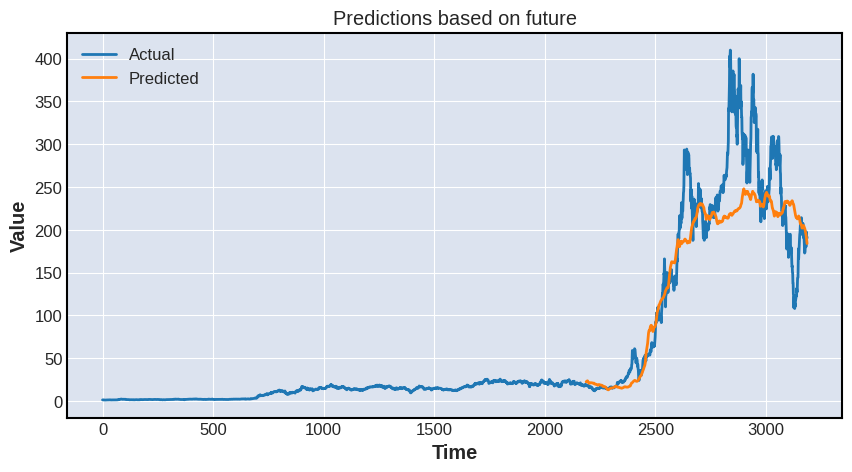

In [11]:
# Perform predictions
predictions_future = model.predict(X_train[-1000:])

# Inverse transform predictions
predictions_future = sc_predict.inverse_transform(predictions_future)

# Create plot
plt.figure(figsize=(10, 5))
plt.plot(testdf[:, 0], label='Actual')
plt.plot(np.arange(len(testdf)-1000, len(testdf)), predictions_future, label='Predicted')
plt.title('Predictions based on future')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

13/13 [==============================] - 0s 24ms/step


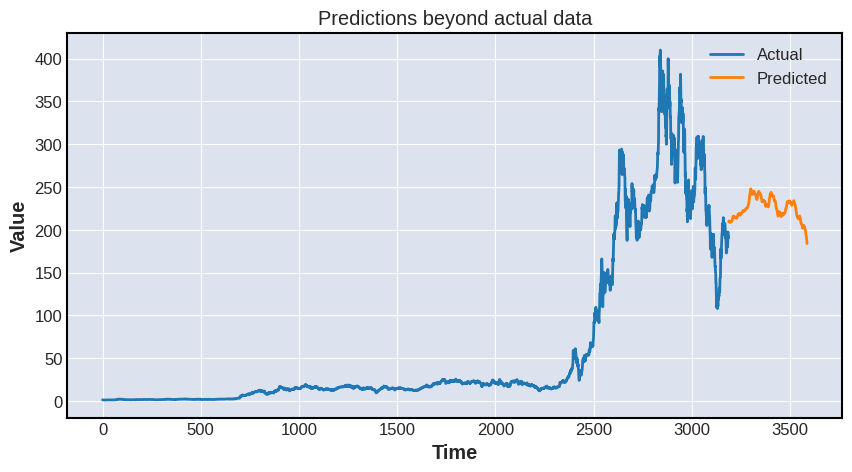

In [12]:
  # Define the number of future time steps to predict
n_future = 400

# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

# Inverse transform predictions
predictions_future = sc_predict.inverse_transform(predictions_future)

# Get the last date in the training data
last_date = testdf[-1, 1]

# Define the future dates to predict
future_dates = pd.date_range(start=last_date, periods=n_future+1, freq='D')[1:]

# Create plot
plt.figure(figsize=(10, 5))
plt.plot(testdf[:, 0], label='Actual')
plt.plot(np.arange(len(testdf), len(testdf)+n_future), predictions_future, label='Predicted')
plt.title('Predictions beyond actual data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


# Analysis
The model is able to make a fairly reasonable prediction based on the findings of the model. it finds for 400 data points after the actual data pile has ended. the predictions seem reasonable since the model was able to retrace the the predictions according to the actual data in the previous plot. the next section includes an analysis of how this may improved in further versions of this project.

## Conclusion

During the development of this project, I was constantly seeking feedback from fellow peers and my supervisor. This included both perspectives, computer programmers and potential users of the program. This initial assessment generally consisted of questions like “would you use this as a tracker for your finance decisions?” or “is this layout something you would consider to be significant enough to be scaled up to a commercial level?”. These were too vague and general in nature. At this stage, the project was being built in a very static way as well. 

The way I got to the dynamic nature of the project as it is now through more detailed questions that were focused on the profession of said reviewer. So for example if the reviewer was a finance expert, the questions would be to ask about the way the features are procured. Talks with finance experts gave me insight on why it is important to select features dynamically. It is because the stock market is a chaotic place, where a lot of changes happen very quickly and it is apparent that, in a broad way, if an analysis is done at one point, it can drastically change the next. The ability of the program to reproduce the same accuracy figures needs to be maintained in order for this project to be worthy of a final year.

There were some additions and omissions from the original preliminary report. One omission was the Adaboost classifier, which was considered as a potential addition to the LSTM model for stock prediction. The Adaboost algorithm is known to be effective in improving the performance of weak classifiers by iteratively training a weak classifier on a weighted version of the training data and then combining the outputs of all the weak classifiers. However, after experimentation, it was found that the LSTM model was already performing well on its own, and the inclusion of the Adaboost classifier did not significantly improve the model's performance. This suggests that the base classifier in the LSTM model was not sufficiently weak to benefit from the Adaboost algorithm. It is worth noting that Adaboost can be effective in improving the performance of a weak classifier, and it could potentially be useful as a classifier strengthener for the news headline feature. This feature requires classification of the correct sentiment to the news headline, and Adaboost could help to improve its performance if implemented as part of further work.

I found that tree-based algorithms either did not work or did not contribute significantly to the results. While I initially considered using decision trees, random forests, or gradient boosting algorithms, I ultimately decided that they were not suitable for the project. These algorithms rely heavily on a large number of features, which are not present in my dataset. Additionally, I found that these models were prone to overfitting, which ultimately made their predictions less reliable.

Moving forward, I believe there are several ways in which I can improve the visualizations in my project. First, I plan to experiment with different chart types and formats to better represent the data. For example, I might use scatterplots or heatmaps to highlight correlations between different variables. I also plan to explore the use of interactive visualizations, which can allow users to explore the data in more detail and gain a deeper understanding of the relationships between different variables.

To support my efforts to improve the visualizations in my project, I have reviewed several academic papers on data visualization. One study that I found particularly useful is "Visualizing Complex Information: Using Interactive Techniques to Support Decision Making" by Peter Pirolli and Stuart Card. This paper discusses the benefits of using interactive visualizations to explore complex datasets, and provides several examples of effective visualization techniques. Another paper that I found helpful is "A Taxonomy of Visualization Techniques using the Data State Reference Model" by R. Daniel Bergeron and colleagues, which provides a framework for understanding the different types of visualizations that are commonly used in data analysis [14,15].

Overall, I believe that by experimenting with different chart types, exploring the use of interactive visualizations, and drawing on the insights from academic research, I can significantly improve the visualizations in my LSTM stock prediction project. The further work that I have suggested may come to life on my github page at Github.com/lordnhell, where this project is also posted
